# SANS2D: I(Q) workflow for a single run (sample)

This notebook describes in detail the steps that are undertaken in the `sans.to_I_of_Q` workflow.

It assumes the detector data has been recorded in event mode, while the monitor data has been histogrammed.

The data used in this notebook has been published in [Manasi et al. (2021)](#manasi2021),
and we kindly thank the authors for allowing us to use their data.

**Note:** It uses sample run for simplicity and it is not intended to describe complete data reduction pipeline.
The complete pipeline is described in [SANS2D reduction](sans2d_reduction.ipynb).

**Outline:**

- We will begin by loading the data files containing the sample and the direct (empty sample holder) measurements.
- We will then apply some corrections to beamline components specific to the SANS2D beamline.
- This will be followed by some masking of some saturated or defect detector pixels
- Both sample and direct measurement, as well as their monitors, will then be converted to wavelength
- From the direct run, and the direct beam function, the normalization term will be computed
- Both sample measurement and normalization term will be converted to $Q$
- Finally, the sample counts (as a function of $Q$) will be divided by the normalization term (as a function of $Q$)

### Using jupyter-lab 

* There are three types of cells: Code, Markdown and Raw
* Press `shift-return` to run a cell and move to next cell
* If things go wrong, `Kernel > Restart kernel and clear all outputs` is often helpful.
* Jupyter will automatically display the last (and only the last) object typed in a cell

In [1]:
a = 5
b = 4
a
b

4

## Import scipp modules

In [2]:
import scipp as sc
from ess import loki, sans
import scippneutron as scn

## Define reduction parameters

We define here whether to include the effects of gravity, and the binning in wavelength and in $Q$ to be used.

In [3]:
# Include effects of gravity?
gravity = True

# Wavelength binning
wavelength_bins = sc.linspace(dim='wavelength', start=2.0, stop=16.0, num=141, unit='angstrom')

# Q binning
q_bins = sc.linspace(dim='Q', start=0.05, stop=0.6, num=201, unit='1/angstrom')

## Loading data files

We load a sample measurement file (`SANS2D00063114.nxs`) and a direct measurement file (`SANS2D00063091.nxs`).
For both files, only the first quarter of pixels will be used, as the rest are used for monitoring.

In [4]:
# Using only one-fourth of the full spectra 245760 (reserved for first detector)
spectrum_size =  245760//4

# Sample measurement
sample = loki.io.load_sans2d(filename=loki.data.get_path('SANS2D00063114.nxs'),
                             spectrum_size=spectrum_size)
# Direct measurement is with the empty sample holder/cuvette
direct = loki.io.load_sans2d(filename=loki.data.get_path('SANS2D00063091.nxs'),
                             spectrum_size=spectrum_size)
sample

FrameworkManager-[Notice] Welcome to Mantid 6.3.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.3
DownloadInstrument-[Notice] All instrument definitions up to date
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 4.67 seconds


Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised units: 'frame_number'
Workspace run log 'good_frame_log' has unrecognised units: 'is_good'
Workspace run log 'period_log' has unrecognised units: 'period_number'
Workspace run log 'raw_events_log' has unrecognised units: 'events'


ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] 

Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised units: 'frame_number'
Workspace run log 'good_frame_log' has unrecognised units: 'is_good'
Workspace run log 'period_log' has unrecognised units: 'period_number'
Workspace run log 'raw_events_log' has unrecognised units: 'events'


ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] ExtractSpectra started
ExtractSpectra-[Notice] ExtractSpectra successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
ExtractSpectra-[Notice] 

<scipp.DataArray>
Dimensions: Sizes[spectrum:61440, tof:1, ]
Coordinates:
  position                  vector3              [m]  (spectrum)  [(-0.5192, -0.48195, 23.281), (-0.517162, -0.48195, 23.281), ..., (0.517162, 0.48195, 23.281), (0.5192, 0.48195, 23.281)]
  sample_position           vector3              [m]  ()  [(0, 0, 19.281)]
  source_position           vector3              [m]  ()  [(0, 0, 0)]
  spectrum                    int32           [None]  (spectrum)  [9, 10, ..., 61447, 61448]
  tof                       float64            [µs]  (tof [bin-edge])  [4.94618, 100006]
Data:
                          DataArrayView           [None]  (spectrum, tof)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:1, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:53:37.686950683]
  tof                       float64            [µs]  (event)  [28523.6]
Data:
                            float32         [counts]  (event)  [1]  [1]

]
Attributes:
  Changer                 DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:2, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000]
Data:
                             string  [dimensionless]  (time)  ["IT", "JT"]

]
  Det_Temp_FLB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [16.8, 16.8, 16.8]

]
  Det_Temp_FLT            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.4, 17.4, 17.4]

]
  Det_Temp_FRB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.4, 17.4, 17.4]

]
  Det_Temp_FRT            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.4, 17.4, 17.4]

]
  Det_Temp_RLB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.8, 17.8, 17.8]

]
  Det_Temp_RLT            DataArray  

## Extract monitors

From these two runs, we extract the data from the incident and transmission monitors,
and place them in their own `dict`, as this will be useful further down.

In [5]:
monitors = {
    'sample': {'incident': sample.attrs["monitor2"].value,
               'transmission': sample.attrs["monitor4"].value},
    'direct': {'incident': direct.attrs["monitor2"].value,
               'transmission': direct.attrs["monitor4"].value}
}

## Apply offsets to pixel positions

**Note:** for production ESS Nexus files are produced, this step should go away.

**Note:** The corrections also include adjusting the beam center position,
which in the future will be determined using helpers in the `ess.sans` package.

Various positions for the sample holder, detector pixels, and monitors are incorrect in the Nexus files.
The step below corrects this.
We also add the shape of the pixels, which is missing from the geometry information,
and is required to compute the solid angle for each detector pixel.

In [6]:
# Custom SANS2D position offsets
sample_pos_z_offset = 0.053 * sc.units.m
bench_pos_y_offset = 0.001 * sc.units.m
# There is some uncertainity here
monitor4_pos_z_offset = -6.719 * sc.units.m

# Geometry transformation based on the found beam center position 
x_offset = -0.1057 * sc.units.m
y_offset = 0.082735 * sc.units.m

In [7]:
# Add pixel shapes
sample.coords["pixel_width"] = 0.0035 * sc.units.m
sample.coords["pixel_height"] = 0.002033984375 * sc.units.m

# Change sample position
sample.coords["sample_position"].fields.z += sample_pos_z_offset
# Apply bench offset to pixel positions
sample.coords["position"].fields.y += bench_pos_y_offset
# Now shift pixels positions to get the correct beam center
sample.coords['position'].fields.x += x_offset
sample.coords['position'].fields.y += y_offset

# Change transmission monitor position
monitors['sample']['transmission'].coords["position"].fields.z += monitor4_pos_z_offset
monitors['direct']['transmission'].coords["position"].fields.z += monitor4_pos_z_offset

## Masking

The next step is to mask noisy and saturated pixels,
as well as a time-of-flight range that contains spurious artifacts from the beamline components.

**Note:** We use programatic masks here and not those stored in xml files.

### Mask bad pixels

We mask the edges of the square-shaped detector panel with a simple distance relation.
We also mask the region close to the beam center, where pixels are saturated.

In [8]:
mask_edges = (
    (sc.abs(sample.coords['position'].fields.x - x_offset) > sc.scalar(0.48, unit='m')) |
    (sc.abs(sample.coords['position'].fields.y - y_offset) > sc.scalar(0.45, unit='m')))

mask_center = sc.sqrt(
    sample.coords['position'].fields.x**2 +
    sample.coords['position'].fields.y**2) < sc.scalar(0.04, unit='m')

sample.masks['edges'] = mask_edges
sample.masks['center'] = mask_center

A good sanity check is to view the masks on the instrument view:

In [9]:
scn.instrument_view(sample, pixel_size=0.0075)

### Mask Bragg peaks in time-of-flight

We will now take out the time regions with Bragg peaks from the beam stop and detector window,
although in reality the peaks appear only close to the beam stop,
and will make little difference to $I(Q)$.

This could be implemented as masking specific time bins for a specific region in space,
but for now we keep it simple.

In [10]:
mask_tof_min = sc.scalar(13000.0, unit='us')
mask_tof_max = sc.scalar(15750.0, unit='us')
tof_masked_region = sc.concat([sample.coords['tof']['tof', 0],
                               mask_tof_min, mask_tof_max,
                               sample.coords['tof']['tof', -1]], dim='tof')

sample = sc.bin(sample, edges=[tof_masked_region])
sample.masks['bragg_peaks'] = sc.array(dims=['tof'], values=[False, True, False])
sample

<scipp.DataArray>
Dimensions: Sizes[spectrum:61440, tof:3, ]
Coordinates:
  pixel_height              float64              [m]  ()  [0.00203398]
  pixel_width               float64              [m]  ()  [0.0035]
  position                  vector3              [m]  (spectrum)  [(-0.6249, -0.398215, 23.281), (-0.622862, -0.398215, 23.281), ..., (0.411462, 0.565685, 23.281), (0.4135, 0.565685, 23.281)]
  sample_position           vector3              [m]  ()  [(0, 0, 19.334)]
  source_position           vector3              [m]  ()  [(0, 0, 0)]
  spectrum                    int32           [None]  (spectrum)  [9, 10, ..., 61447, 61448]
  tof                       float64            [µs]  (tof [bin-edge])  [4.94618, 13000, 15750, 100006]
Data:
                          DataArrayView           [None]  (spectrum, tof)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:1, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:53:37.686950683]
  tof                       float64            [µs]  (event)  [28523.6]
Data:
                            float32         [counts]  (event)  [1]  [1]

]
Masks:
  bragg_peaks                  bool           [None]  (tof)  [False, True, False]
  center                       bool           [None]  (spectrum)  [False, False, ..., False, False]
  edges                        bool           [None]  (spectrum)  [True, True, ..., True, True]
Attributes:
  Changer                 DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:2, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000]
Data:
                             string  [dimensionless]  (time)  ["IT", "JT"]

]
  Det_Temp_FLB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [16.8, 16.8, 16.8]

]
  Det_Temp_FLT            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.4, 17.4, 17.4]

]
  Det_Temp_FRB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensionless]  (time)  [17.4, 17.4, 17.4]

]
  Det_Temp_FRT            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000, 2020-02-12T21:08:13.000000000]
Data:
                            float64  [dimensi

## Coordinate transformation graph

To compute the wavelength $\lambda$, the scattering angle $\theta$, and the $Q$ vector for our data,
we construct a coordinate transformation graph.

It is based on classical conversions from `tof` and pixel `position` to $\lambda$ (`wavelength`),
$\theta$ (`theta`) and $Q$ (`Q`),
but takes into account the Earth's gravitational field, which bends the flight path of the neutrons,
to compute the scattering angle $\theta$.

The angle can be found using the following expression ([Seeger & Hjelm 1991](#seeger1991))

$$\theta = \frac{1}{2}\sin^{-1}\left(\frac{\sqrt{ x^{2} + \left( y + \frac{g m_{\rm n}}{2 h^{2}} \lambda^{2} L_{2}^{2} \right)^{2} } }{L_{2}}\right)$$

where $x$ and $y$ are the spatial coordinates of the pixels in the horizontal and vertical directions, respectively,
$m_{\rm n}$ is the neutron mass,
$L_{2}$ is the distance between the sample and a detector pixel,
$g$ is the acceleration due to gravity,
and $h$ is Planck's constant.

The monitors require a slightly different conversion graph,
as the flight path of the neutrons hitting them does not scatter through the sample,
it links the source to the monitor with a straight line.

The conversion graphs for the detectors and the monitors are defined in the `sans` module,
and can be obtained via

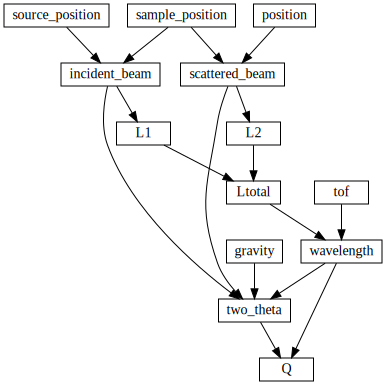

In [11]:
data_graph, monitor_graph = sans.i_of_q.make_coordinate_transform_graphs(gravity=gravity)
sc.show_graph(data_graph, simplified=True)

## Convert the data to wavelength

To compute the wavelength of the neutrons,
we use Scipp's `transform_coords` method by supplying our graph defined above
(see [here](https://scipp.github.io/scippneutron/user-guide/coordinate-transformations.html)
for more information about using `transform_coords`) to a helper conversion function.

In [12]:
sample, monitors = sans.i_of_q.convert_to_wavelength(
    data=sample,
    monitors=monitors,
    data_graph=data_graph,
    monitor_graph=monitor_graph)

## Compute normalization term

In a SANS experiment, the scattering cross section $I(Q)$ is defined as ([Heenan et al. 1997](#heenan1997))

$$ I(Q) = \frac{\partial\Sigma{Q}}{\partial\Omega} = \frac{A_{H} \Sigma_{R,\lambda\subset Q} C(R, \lambda)}{A_{M} t \Sigma_{R,\lambda\subset Q}M(\lambda)T(\lambda)D(\lambda)\Omega(R)} $$

where $A_{H}$ is the area of a mask (which avoids saturating the detector) placed between the monitor of area $A_{M}$ and the main detector.
$\Omega$ is the detector solid angle, and $C$ is the count rate on the main detector, which depends on the position $R$ and the wavelength.
$t$ is the sample thickness, $M$ represents the incident monitor count rate, and $T$ is known as the transmission fraction.
Finally, $D$ is the 'direct beam function', and is defined as

$$ D(\lambda) = \frac{\eta(\lambda)}{\eta_{M}(\lambda)} \frac{A_{H}}{A_{M}} $$

where $\eta$ and $\eta_{M}$ are the detector and monitor efficiencies, respectively.

Hence, in order to normalize the main detector counts $C$, we need compute the transmission fraction $T(\lambda)$,
the direct beam function $D(\lambda)$ and the solid angle $\Omega(R)$.

### Transmission fraction

The transmission fraction is computed from the monitor counts.
It essentially compares the neutron counts before the sample, and after the sample,
to give an absorption profile of the sample as a function of wavelength.

It is defined as the ratio of counts between on the transmission monitor to the counts on the incident monitor for the sample run,
multiplied by the inverse ratio for the direct run, i.e.

$$ T(\lambda) = \frac{M_{\rm sample}^{\rm transmission}}{M_{\rm sample}^{\rm incident}} \frac{M_{\rm direct}^{\rm incident}}{M_{\rm direct}^{\rm transmission}} $$

#### Remove background noise and rebin monitors

To compute the ratios, the monitor counts are first cleaned of background noise counts.
By looking at the monitors on a plot,

In [13]:
p = sc.plot(monitors['sample'], norm='log')
sc.plot(monitors['direct'], norm='log', ax=p.ax, color=['C2', 'C3'])
p

we define a valid wavelength range between 0.7 &#8491; and 17.1 &#8491;.

In [14]:
non_background_range = sc.array(dims=['wavelength'], values=[0.7, 17.1], unit='angstrom')

and we remove the mean background counts and rebin the monitors in a single step using

In [15]:
monitors = sans.i_of_q.denoise_and_rebin_monitors(
    monitors=monitors,
    wavelength_bins=wavelength_bins,
    non_background_range=non_background_range)

The transmission fraction is then computed by using 

In [16]:
transmission_fraction = sans.normalization.transmission_fraction(
    data_monitors=monitors['sample'], direct_monitors=monitors['direct'])
transmission_fraction

<scipp.DataArray>
Dimensions: Sizes[wavelength:140, ]
Coordinates:
  wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 2.1, ..., 15.9, 16]
Data:
                            float64  [dimensionless]  (wavelength)  [0.763918, 0.766274, ..., 0.521747, 0.541551]  [8.7976e-06, 7.15546e-06, ..., 0.000181176, 0.000199068]
Attributes:
  instrument_name            string           [None]  ()  ["SANS2D"]
  sample_position           vector3              [m]  ()  [(0, 0, 19.281)]
  source_position           vector3              [m]  ()  [(0, 0, 0)]

In [17]:
transmission_fraction.plot()

### Smoothing transmission fraction function (work in progress)

In [ ]:
from scipp.signal import butter, sosfiltfilt

trans_fract = transmission_fraction
midpoints = sc.midpoints(transmission_fraction.coords['wavelength'])
trans_fract.coords['wavelength'] = midpoints

sos = butter(transmission_fraction.coords['wavelength'], N=4, Wn=1/ sc.units.angstrom)
signal_processed = sosfiltfilt(sc.values(trans_fract), 'wavelength', sos=sos)

sc.plot({'original':  transmission_fraction, 'processed': signal_processed})

### Direct beam function

The direct beam function is a parameter of the instrument that is well-known to the instrument scientist,
and does not vary much over time.
It is usually stored in a file, and updated a small number of times per year.

Here, we load the direct beam function for the SANS2D instrument from file,
and perform an interpolation so that it spans the same wavelength range as the one requested at the top of the notebook.

In [18]:
# Load direct beam function for main detector
direct_beam = loki.io.load_rkh_wav(loki.data.get_path('DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.dat'))

direct_beam = sans.i_of_q.resample_direct_beam(
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins)

sc.plot(direct_beam)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


LoadRKH-[Notice] LoadRKH started
LoadRKH-[Notice] LoadRKH successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


### Solid Angle

The `sans.normalization` module also provides a utility to compute the solid angles of rectangular detector pixels:

In [19]:
solid_angle = sans.normalization.solid_angle_of_rectangular_pixels(
    sample,
    pixel_width=sample.coords['pixel_width'],
    pixel_height=sample.coords['pixel_height'])
solid_angle

<scipp.Variable> (spectrum: 61440)    float64  [dimensionless]  [4.41406e-07, 4.41476e-07, ..., 4.43048e-07, 4.43002e-07]

### The denominator term

We combine all the terms above to compute the `denominator`.
We then attach to the denominator some coordinates required to perform the conversion to $Q$.

In [20]:
denominator = sans.normalization.compute_denominator(
        direct_beam=direct_beam,
        data_incident_monitor=monitors['sample']['incident'],
        transmission_fraction=transmission_fraction,
        solid_angle=solid_angle)
# Insert a copy of coords needed for conversion to Q.
# TODO: can this be avoided by copying the Q coords from the converted numerator?
for coord in ['position', 'sample_position', 'source_position']:
    denominator.coords[coord] = sample.meta[coord]

denominator

<scipp.DataArray>
Dimensions: Sizes[spectrum:61440, wavelength:140, ]
Coordinates:
  position                  vector3              [m]  (spectrum)  [(-0.6249, -0.398215, 23.281), (-0.622862, -0.398215, 23.281), ..., (0.411462, 0.565685, 23.281), (0.4135, 0.565685, 23.281)]
  sample_position           vector3              [m]  ()  [(0, 0, 19.334)]
  source_position           vector3              [m]  ()  [(0, 0, 0)]
  wavelength                float64             [Å]  (wavelength)  [2.05, 2.15, ..., 15.85, 15.95]
Data:
                            float64         [counts]  (spectrum, wavelength)  [0.0243972, 0.0261141, ..., 7.93034e-05, 8.00852e-05]  [1.16699e-08, 1.07718e-08, ..., 5.36679e-12, 5.58278e-12]

In [ ]:
sc.plot(denominator.sum('spectrum'), norm='log')

## Convert to Q

Using the coordinate transformation graph as above,
we can compute the momentum vector $Q$, and then merge all the events in the detector pixel bins,
so as to obtain an intensity that depends only on $Q$.

This is done with the `convert_to_q_and_merge_spectra` helper.

In [21]:
wavelength_bands = sc.concat(
            [wavelength_bins.min(), wavelength_bins.max()], dim='wavelength')

In [22]:
sample_q = sans.i_of_q.convert_to_q_and_merge_spectra(
    data=sample,
    graph=data_graph,
    wavelength_bands=wavelength_bands,
    q_bins=q_bins,
    gravity=gravity)

In [23]:
sc.plot(sample_q, norm='log')

### Convert denominator to Q

Converting the denominator to $Q$ is achieved in the same way

In [24]:
denominator_q = sans.i_of_q.convert_to_q_and_merge_spectra(
    data=denominator,
    graph=data_graph,
    wavelength_bands=wavelength_bands,
    q_bins=q_bins,
    gravity=True)

sc.plot(denominator_q, norm='log')

## Normalize the sample

Finally, we normalize the sample with the denominator as a function of $Q$.

In [25]:
sample_normalized = sans.normalization.normalize(
    numerator=sample_q,
    denominator=denominator_q)
sample_normalized

<scipp.DataArray>
Dimensions: Sizes[Q:200, ]
Coordinates:
  Q                         float64           [1/Å]  (Q [bin-edge])  [0.05, 0.05275, ..., 0.59725, 0.6]
  pixel_height              float64              [m]  ()  [0.00203398]
  pixel_width               float64              [m]  ()  [0.0035]
Data:
                          DataArrayView           [None]  (Q)  [<scipp.DataArray>
Dimensions: Sizes[event:137193, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  [0.0526554, 0.0520015, ..., 0.0526187, 0.0523999]
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:47:21.687988281, 2020-02-12T21:04:03.186035156, ..., 2020-02-12T20:54:28.986999511, 2020-02-12T21:03:52.086059570]
  wavelength                float64             [Å]  (event)  [2.20521, 2.20736, ..., 15.8692, 15.9936]
Data:
                            float32  [dimensionless]  (event)  [0.00199008, 0.00199008, ..., 0.00199008, 0.00199008]  [3.96042e-06, 3.96042e-06, ..., 3.96042e-06, 3.96042e-06]
Attributes:
  tof                       float64            [µs]  (event)  [12977.9, 12990.5, ..., 93531, 94265]
  two_theta                 float64            [rad]  (event)  [0.0184807, 0.018269, ..., 0.132995, 0.133481]

, <scipp.DataArray>
Dimensions: Sizes[event:153821, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  [0.0553751, 0.0550477, ..., 0.0547275, 0.0549504]
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T21:05:01.085937500, 2020-02-12T20:42:11.988006591, ..., 2020-02-12T20:59:40.286010742, 2020-02-12T20:42:06.688003540]
  wavelength                float64             [Å]  (event)  [2.20716, 2.20597, ..., 15.9228, 15.9505]
Data:
                            float32  [dimensionless]  (event)  [0.0018922, 0.0018922, ..., 0.0018922, 0.0018922]  [3.58041e-06, 3.58041e-06, ..., 3.58041e-06, 3.58041e-06]
Attributes:
  tof                       float64            [µs]  (event)  [12989.4, 12982.4, ..., 93859.4, 94024.6]
  two_theta                 float64            [rad]  (event)  [0.0194525, 0.0193271, ..., 0.138801, 0.13961]

, ..., <scipp.DataArray>
Dimensions: Sizes[event:3, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  [0.596838, 0.595613, 0.595988]
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T21:05:26.585937500, 2020-02-12T21:05:04.685913085, 2020-02-12T20:44:48.488006591]
  wavelength                float64             [Å]  (event)  [2.01774, 2.02973, 2.04017]
Data:
                            float32  [dimensionless]  (event)  [0.857046, 0.857046, 0.857046]  [0.734528, 0.734528, 0.734528]
Attributes:
  tof                       float64            [µs]  (event)  [11911.9, 11983, 12045.1]
  two_theta                 float64            [rad]  (event)  [0.191959, 0.192706, 0.193822]

, <scipp.DataArray>
Dimensions: Sizes[event:2, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  [0.598863, 0.598921]
  pulse_time              datetime64             [ns]  (event)  [2020-02-12T21:06:25.986083984, 2020-02-12T21:08:04.786010742]
  wavelength                float64             [Å]  (event)  [2.02262, 2.00325]
Data:
                            float32  [dimensionless]  (event)  [0.986077, 0.986077]  [0.972348, 0.972348]
Attributes:
  tof                       float64            [µs]  (event)  [11941.2, 11826.1]
  two_theta                 float64            [rad]  (event)  [0.19308, 0.191244]

]
Attributes:
  Changer                 DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:2, ]
Coordinates:
  time                    datetime64             [ns]  (time)  [2020-02-12T20:37:41.000000000, 2020-02-12T20:38:00.000000000]
Data:
                             string  [dimensionless]  (time)  ["IT", "JT"]

]
  Det_Temp_FLB            DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:3, ]
Coordinates:
  time                    datet

In [26]:
sc.plot(sample_normalized)

## References

<div id='heenan1997'></div>

Heenan R. K., Penfold J., King S. M., **1997**,
*SANS at Pulsed Neutron Sources: Present and Future Prospects*,
[J. Appl. Cryst., 30, 1140-1147](https://doi.org/10.1107/S0021889897002173)

<div id='manasi2021'></div>

Manasi I., Andalibi M. R., Atri R. S., Hooton J., King S. M., Edler K. J., **2021**,
*Self-assembly of ionic and non-ionic surfactants in type IV cerium nitrate and urea based deep eutectic solvent*,
[J. Chem. Phys. 155, 084902](https://doi.org/10.1063/5.0059238)

<div id='seeger1991'></div>

Seeger P. A., Hjelm R. P. Jnr, **1991**,
*Small-angle neutron scattering at pulsed spallation sources*,
[J. Appl. Cryst., 24, 467-478](https://doi.org/10.1107/S0021889891004764)